In [9]:
# Install missing dependencies if needed
!pip install scikit-learn tqdm --quiet

# Data Preprocessing

In [10]:
import sys
print("Python executable:", sys.executable)
!which python
!python --version

Python executable: /Users/animesh/miniforge3/envs/tfmac/bin/python
/Users/animesh/miniforge3/envs/tfmac/bin/python
Python 3.9.22


In [11]:
try:
    import tqdm
    print("tqdm is available")
except ImportError:
    print("tqdm is NOT available")

tqdm is available


In [12]:
# 1. Install and Import Dependencies
# Ensure this cell is run and wfdb is installed successfully
!pip install wfdb

import os
import numpy as np
import wfdb
from scipy.signal import butter, filtfilt
from tqdm import tqdm
import zipfile # Added for completeness, though your original code had it
from sklearn.model_selection import train_test_split # We'll use this for splitting patient records
import pandas as pd
import matplotlib.pyplot as plt
from wfdb import processing # For R-peak detection
from scipy.signal import welch
from scipy.integrate import trapezoid
import tensorflow as tf
from tensorflow.keras import layers, models
import platform

In [13]:
import os
import platform

# Enable Metal acceleration for Apple Silicon
os.environ['TF_METAL_DEVICE_FORCE_MEMORY_GROWTH'] = 'true'

print(f"Platform: {platform.platform()}")
print(f"Processor: {platform.processor()}")

is_apple_silicon = platform.processor() == 'arm'
print(f"Is Apple Silicon: {is_apple_silicon}")

try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
    print(f"Available devices: {tf.config.list_physical_devices()}")
    if is_apple_silicon:
        print("Configuring TensorFlow for Apple Silicon...")
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision enabled")
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU memory growth enabled for {len(gpus)} device(s)")
except ImportError:
    print("TensorFlow not installed. Install with: pip install tensorflow-macos tensorflow-metal")

Platform: macOS-15.4.1-arm64-arm-64bit
Processor: arm
Is Apple Silicon: True
TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configuring TensorFlow for Apple Silicon...
Mixed precision enabled
GPU memory growth enabled for 1 device(s)


In [14]:
# 2. Setup ZIP and extraction dir
#zip_path = '/content/mit-bih-atrial-fibrillation-database-1.0.0.zip'
zip_path = 'mit-bih-atrial-fibrillation-database-1.0.0.zip'
data_dir = 'afdb'

# Extract if needed (Your existing extraction logic is fine here)
if not os.path.isdir(data_dir):
    if not zipfile.is_zipfile(zip_path):
        raise RuntimeError(
            f"Uploaded file '{zip_path}' is not a valid ZIP.\\n"
            "Upload the correct AFDB ZIP containing .dat, .hea, .atr files."
        )
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(data_dir)
    print(f"Extracted '{zip_path}' to '{data_dir}/'")
else:
    print(f"Using existing directory '{data_dir}/'")

# 3. Recursively find .dat files and corresponding base paths
# This gives us a list of (record_base_name, directory_path)
record_info_list = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.dat'):
            rec_base = os.path.splitext(file)[0]
            rec_dir = root
            record_info_list.append({'rec_base': rec_base, 'rec_dir': rec_dir, 'rec_id': rec_base}) # Assuming rec_base is a unique patient identifier

if not record_info_list:
    raise RuntimeError(
        f"No .dat files found under '{data_dir}/'. Check that the ZIP contains the raw ECG .dat recordings."
    )
print(f"Found {len(record_info_list)} records with .dat files.")

# --- START: REPLACEMENT FOR PATIENT-AWARE SPLIT (NOW STRATIFIED) ---
# --- REVISED: Stratified Patient-Aware Train/Test Split ---
# 1. Determine a patient-level label (does the patient have ANY AF segments based on aux_note?)
patient_level_has_af = []
for rec_info in tqdm(record_info_list, desc="Determining patient-level AF status for stratification"):
    rec_path = os.path.join(rec_info['rec_dir'], rec_info['rec_base'])
    has_af_in_record = False
    try:
        ann = wfdb.rdann(rec_path, 'atr')
        # Check aux_note for rhythm annotations
        if any('(AFIB' in note.strip() or '(AFL' in note.strip() for note in ann.aux_note):
            has_af_in_record = True
    except Exception as e:
        print(f"Could not process annotations for {rec_path} for stratification: {e}")
    patient_level_has_af.append(has_af_in_record)

patient_level_has_af = np.array(patient_level_has_af)
print(f"Patient-level AF status (True means patient has AF): {patient_level_has_af}")
print(f"Counts - Patients with AF: {np.sum(patient_level_has_af)}, Patients without AF: {len(patient_level_has_af) - np.sum(patient_level_has_af)}")

# ... (the rest of your train_test_split logic using this revised patient_level_has_af) ...
# (Keep the can_stratify check and the train_test_split call as you had it from my previous response)


# Check if stratification is possible
unique_patient_classes, counts_patient_classes = np.unique(patient_level_has_af, return_counts=True)
# Stratification requires at least 2 samples for each class in the smallest set (test set if test_size < 0.5)
# A common rule of thumb for train_test_split is n_splits samples per class.
# Given test_size=0.2 (5 patients in test for 23 total), we need at least 1 AF and 1 Non-AF patient in test.
# So, we need at least a few AF patients overall.
# Let's simplify: ensure there are at least 2 patients in the minority class overall for stratification to attempt.
can_stratify = all(count >= 2 for count in counts_patient_classes) and len(unique_patient_classes) > 1

if can_stratify:
    print("Attempting stratified split at patient level.")
    train_records_info, test_records_info = train_test_split(
        record_info_list,
        test_size=0.2, # Adjust as needed
        stratify=patient_level_has_af, # Stratify based on patient-level AF status
        random_state=42
    )
else:
    print("Cannot perform robust stratified split due to insufficient class representation at patient level for the given test_size.")
    print("Consider a larger dataset, different test_size, or cross-validation for more robust evaluation if one class of patients is too rare.")
    print("Falling back to random split for now, but be aware of potential imbalance in the test set.")
    train_records_info, test_records_info = train_test_split(
        record_info_list,
        test_size=0.2,
        random_state=42
    )

print(f"Split into {len(train_records_info)} training records and {len(test_records_info)} testing records.")
# --- END: REPLACEMENT FOR PATIENT-AWARE SPLIT (NOW STRATIFIED) ---


# 4. Filtering parameters and definitions (Your existing code is fine)
FS = 250  # Hz
WINDOW_SEC = 5
WINSZ = WINDOW_SEC * FS

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    return butter(order, [lowcut/nyq, highcut/nyq], btype='band')

def bandpass_filter(sig, lowcut=0.5, highcut=40.0, fs=FS, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, sig)

# 5. Segmentation + normalization (Your existing code is fine)
def segment_and_normalize(sig):
    n = len(sig) // WINSZ
    segments = []
    for i in range(n):
        w = sig[i*WINSZ:(i+1)*WINSZ]
        if np.std(w) == 0: # Avoid division by zero for flat segments
            segments.append(w - np.mean(w))
        else:
            segments.append((w - np.mean(w)) / np.std(w))
    return np.stack(segments) if segments else np.array([])


# 6. Label extraction (REVISED for Rhythm-Based Labeling)

def get_rhythm_label_for_segment(ann_samples, ann_aux_notes, segment_start_sample, segment_end_sample):
    """
    Determines the rhythm label for a given segment.
    Prioritizes AFIB/AFL if they occur anywhere in the segment's rhythm annotations.
    Otherwise, takes the rhythm active at the start of the segment.
    """
    relevant_rhythm_ann_indices = np.where((ann_samples < segment_end_sample))[0]

    current_rhythm = 'N' # Default to Normal or Non-AF
    found_specific_rhythm = False

    if len(relevant_rhythm_ann_indices) > 0:
        # Iterate backwards through annotations affecting the segment or starting before it
        for i in reversed(relevant_rhythm_ann_indices):
            ann_time = ann_samples[i]
            note = ann_aux_notes[i].strip() # Ensure to strip whitespace

            if ann_time < segment_end_sample : # This annotation is active before or during the segment
                if note == '(AFIB' or note == '(AFL':
                    # If AFIB/AFL starts before or within this segment and ends after segment starts
                    # Check if this rhythm covers the segment
                    next_ann_time = float('inf')
                    if i + 1 < len(ann_samples):
                        next_ann_time = ann_samples[i+1]

                    # If this rhythm (AFIB/AFL) is active at any point within the segment
                    if ann_time < segment_end_sample and next_ann_time > segment_start_sample:
                        return 'AF' # Label segment as AF

                if not found_specific_rhythm and ann_time <= segment_start_sample:
                    # This is the rhythm active at the start of the segment if no AF found yet
                    if note == '(N':
                        current_rhythm = 'N'
                    elif note == '(VT': # Ventricular Tachycardia
                        current_rhythm = 'VT' # Example, add others as needed
                    # Add other rhythm types if necessary
                    else:
                        current_rhythm = 'OTHER' # A generic "other rhythm"
                    found_specific_rhythm = True # Found the rhythm at segment start

    # If after checking all relevant annotations, no AF was found covering the segment,
    # return the rhythm that was active at the start of the segment, or default.
    # For binary, we simplify: if not AF, then NonAF (represented by 'N' here)
    if current_rhythm != 'AF': # This check might be redundant if AF is returned directly
        return 'N' # Or a more general NonAF label
    return current_rhythm # Should be 'AF' if reached here

# Define the map_to_is_af function here, before it's called
def map_to_is_af(original_labels_array):
    return np.isin(original_labels_array, ['AFIB', 'AFL'])


# 7. Process records (Modified to create separate train/test sets)
os.makedirs('processed_patient_split', exist_ok=True)

def process_records(records_info_list, set_name):
    all_segments_for_set = []
    all_labels_for_set = []
    all_record_ids_for_set = [] # To keep track of which patient each segment belongs to (optional, but good for debugging)

    for rec_info in tqdm(records_info_list, desc=f'Preprocessing {set_name} set'):
        rec_path = os.path.join(rec_info['rec_dir'], rec_info['rec_base'])
        try:
            record = wfdb.rdrecord(rec_path)
            ann = wfdb.rdann(rec_path, 'atr')
        except Exception as e:
            print(f"Error reading record {rec_path}: {e}")
            continue

        raw = record.p_signal[:, 0]
        filt = bandpass_filter(raw)
        segs = segment_and_normalize(filt)

        if segs.shape[0] > 0:
            # --- MODIFIED LABELING CALL ---
            # Ensure ann.sample and ann.aux_note are numpy arrays for efficiency if large
            np_ann_sample = np.array(ann.sample)
            np_ann_aux_note = np.array(ann.aux_note)

            labels = [get_rhythm_label_for_segment(np_ann_sample, np_ann_aux_note,
                                                   i*WINSZ, (i+1)*WINSZ)
                      for i in range(segs.shape[0])]
            # --- END OF MODIFIED LABELING CALL ---
            all_segments_for_set.append(segs)
            all_labels_for_set.extend(labels)
            all_record_ids_for_set.extend([rec_info['rec_id']] * len(segs))
# ... rest of process_records ...

    if not all_segments_for_set: # Handle case where no segments are generated
        return np.array([]), np.array([]), np.array([])

    final_segments = np.vstack(all_segments_for_set)
    final_labels = np.array(all_labels_for_set)
    final_record_ids = np.array(all_record_ids_for_set)

    np.save(f'processed_patient_split/{set_name}_segments.npy', final_segments)
    np.save(f'processed_patient_split/{set_name}_labels.npy', final_labels)
    np.save(f'processed_patient_split/{set_name}_record_ids.npy', final_record_ids) # Optional
    print(f"Saved {final_segments.shape[0]} segments for {set_name} set to 'processed_patient_split/'")
    return final_segments, final_labels, final_record_ids

# Process training records
train_segments, train_labels, train_record_ids = process_records(train_records_info, 'train')
# Process testing records
test_segments, test_labels, test_record_ids = process_records(test_records_info, 'test')

print("Data preprocessing with patient-aware split complete.")


# --- START: INSERTION FOR CLASS DISTRIBUTION VERIFICATION ---
print("\n--- Original Label Distribution in Patient-Split Sets (After Stratification Attempt) ---")

# Ensure train_labels and test_labels are not empty before proceeding
if train_labels.size > 0:
    unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)
    print("Train Set Original Labels (segment-level):")
    for label, count in zip(unique_train_labels, counts_train_labels):
        print(f"  Label '{label}': {count} segments")
else:
    print("Train set has no labels (train_labels is empty).")

if test_labels.size > 0:
    unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)
    print("\nTest Set Original Labels (segment-level):")
    for label, count in zip(unique_test_labels, counts_test_labels):
        print(f"  Label '{label}': {count} segments")
else:
    print("Test set has no labels (test_labels is empty).")


# Map to binary AF/Non-AF to check distribution for y_true
# Now the function map_to_is_af is defined above this block
if train_labels.size > 0:
    train_is_af_dist = map_to_is_af(train_labels)
    print("\nTrain Set Binary AF/Non-AF Distribution (segment-level, True means AF):")
    print(pd.Series(train_is_af_dist).value_counts(normalize=True))
    print(pd.Series(train_is_af_dist).value_counts())
else:
    print("Train set is empty for binary distribution check.")

if test_labels.size > 0:
    test_is_af_dist = map_to_is_af(test_labels)
    print("\nTest Set Binary AF/Non-AF Distribution (segment-level, True means AF):")
    print(pd.Series(test_is_af_dist).value_counts(normalize=True))
    print(pd.Series(test_is_af_dist).value_counts())

    # Crucial check for the test set having both classes
    if len(np.unique(test_is_af_dist)) < 2:
        print("\nWARNING: The test set (after segment processing) contains only one class for AF/Non-AF.")
        print("This will lead to issues with metrics like AUC and potentially with model evaluation.")
        print("Consider adjusting your patient split strategy or using cross-validation if this is unavoidable with a small dataset.")
    else:
        print("\nTest set contains both AF and Non-AF segments after processing.")
else:
    print("Test set is empty for binary distribution check.")
# --- END: INSERTION FOR CLASS DISTRIBUTION VERIFICATION ---

Using existing directory 'afdb/'
Found 23 records with .dat files.


Determining patient-level AF status for stratification: 100%|████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.49it/s]


Patient-level AF status (True means patient has AF): [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
Counts - Patients with AF: 23, Patients without AF: 0
Cannot perform robust stratified split due to insufficient class representation at patient level for the given test_size.
Consider a larger dataset, different test_size, or cross-validation for more robust evaluation if one class of patients is too rare.
Falling back to random split for now, but be aware of potential imbalance in the test set.
Split into 18 training records and 5 testing records.


Preprocessing train set: 100%|████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.35it/s]


Saved 131848 segments for train set to 'processed_patient_split/'


Preprocessing test set: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


Saved 36820 segments for test set to 'processed_patient_split/'
Data preprocessing with patient-aware split complete.

--- Original Label Distribution in Patient-Split Sets (After Stratification Attempt) ---
Train Set Original Labels (segment-level):
  Label 'AF': 54793 segments
  Label 'N': 77055 segments

Test Set Original Labels (segment-level):
  Label 'AF': 13903 segments
  Label 'N': 22917 segments

Train Set Binary AF/Non-AF Distribution (segment-level, True means AF):
False    1.0
Name: proportion, dtype: float64
False    131848
Name: count, dtype: int64

Test Set Binary AF/Non-AF Distribution (segment-level, True means AF):
False    1.0
Name: proportion, dtype: float64
False    36820
Name: count, dtype: int64

This will lead to issues with metrics like AUC and potentially with model evaluation.
Consider adjusting your patient split strategy or using cross-validation if this is unavoidable with a small dataset.


In [15]:
# # 1. EDA: load data and plot
# import numpy as np
# import matplotlib.pyplot as plt
# from wfdb import processing


In [16]:
# # Load preprocessed segments and labels
# segments = np.load('processed/segments.npy')  # shape (N, 1250)
# labels   = np.load('processed/labels.npy')    # shape (N,)

# # Map labels to two classes: AF vs Non-AF
# is_af = np.isin(labels, ['AFIB', 'AFL'])

# # 1.1 Plot random raw & filtered windows
# idx = np.random.choice(len(segments), 4, replace=False)
# fig, axes = plt.subplots(2, 2, figsize=(12, 6))
# for ax, i in zip(axes.flatten(), idx):
#     ax.plot(segments[i])
#     ax.set_title(f"Segment {i} – {'AF' if is_af[i] else 'Non-AF'}")
#     ax.set_xlabel("Sample (5 s @250 Hz)")
# plt.tight_layout()
# plt.show()

# # 1.2 Amplitude distribution
# plt.figure(figsize=(6,4))
# plt.hist(segments.flatten(), bins=100, density=True)
# plt.title("Histogram of Z-scored ECG Samples")
# plt.xlabel("Amplitude (z-score)")
# plt.ylabel("Density")
# plt.show()

# # 1.3 RR-interval histogram for a sample segment
# # Detect R-peaks on one segment
# signal = segments[idx[0]]
# peaks = processing.gqrs_detect(sig=signal, fs=250)
# rr_intervals = np.diff(peaks) / 250.0  # in seconds

# plt.figure(figsize=(6,4))
# plt.hist(rr_intervals, bins=30)
# plt.title("RR-Interval Distribution (Sample Segment)")
# plt.xlabel("RR Interval (s)")
# plt.ylabel("Count")
# plt.show()

# # 1.4 Class balance
# import pandas as pd
# counts = pd.Series(is_af).map({False:'Non-AF', True:'AF'}).value_counts()
# counts.plot.bar(figsize=(4,4))
# plt.title("AF vs Non-AF Segment Counts")
# plt.ylabel("Number of Segments")
# plt.show()

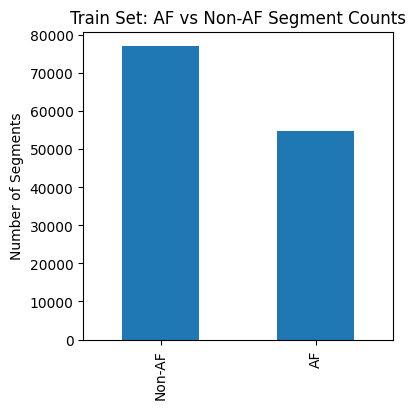

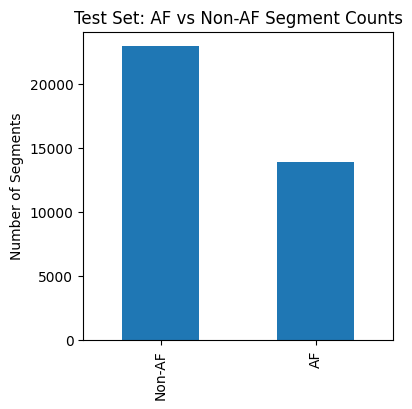

Extracting features for TEST set: 100%|█████████████████████████████████████████████████████████████████████████| 36820/36820 [07:02<00:00, 87.06it/s]


X_train_feat_df shape before NaN drop: (131848, 5)
X_train_feat_df shape after NaN drop: (131747, 5)
X_test_feat_df shape before NaN drop: (36820, 5)
X_test_feat_df shape after NaN drop: (36800, 5)
Feature extraction complete.


,mean_rr,sdnn,rmssd,cv_rr,power
0,0.614667,0.015731,0.015073,0.025593,0.864387
1,0.611333,0.014624,0.011027,0.023922,0.873469
2,0.622667,0.014010,0.013856,0.022499,0.818226
3,0.614667,0.015731,0.012394,0.025593,0.934080
4,0.616000,0.021166,0.022509,0.034360,1.075735


In [17]:
# --- EDA: Load data and plot (Adjust as needed) ---
# You'll now load the patient-split data. For EDA, you might combine them
# or analyze train/test separately.
# For now, let's assume segments and labels variables are for training for EDA visualization purposes if needed.
# Or, load 'train_segments.npy' and 'train_labels.npy' for EDA
segments_for_eda = np.load('processed_patient_split/train_segments.npy')
labels_for_eda = np.load('processed_patient_split/train_labels.npy')

# Map labels to two classes: AF vs Non-AF
# IMPORTANT: Apply this mapping consistently to train_labels and test_labels
# In your EDA / Feature Extraction section
def map_to_is_af(original_labels_array):
    # Assuming get_rhythm_label_for_segment returns 'AF' for atrial fibrillation
    return np.isin(original_labels_array, ['AF'])

train_is_af = map_to_is_af(train_labels)
test_is_af = map_to_is_af(test_labels)

# (Your EDA plotting code can go here, using segments_for_eda and corresponding mapped labels)
# Example: Class balance for training set
counts_train = pd.Series(train_is_af).map({False:'Non-AF', True:'AF'}).value_counts()
counts_train.plot.bar(figsize=(4,4))
plt.title("Train Set: AF vs Non-AF Segment Counts")
plt.ylabel("Number of Segments")
plt.show()

counts_test = pd.Series(test_is_af).map({False:'Non-AF', True:'AF'}).value_counts()
counts_test.plot.bar(figsize=(4,4))
plt.title("Test Set: AF vs Non-AF Segment Counts")
plt.ylabel("Number of Segments")
plt.show()


# --- Feature Extraction (Modified) ---
# Ensure wfdb is imported if this cell is run independently
# from wfdb import processing # Already imported earlier

def extract_features(seg, fs=250):
    # Your existing extract_features function (ensure it handles empty segs or few peaks)
    peaks = processing.gqrs_detect(sig=seg, fs=fs)
    if len(peaks) < 2:
        return {
            'mean_rr': np.nan, 'sdnn': np.nan,
            'rmssd': np.nan,   'cv_rr': np.nan,
            'power': np.nan
        }
    rr = np.diff(peaks) / fs
    mean_rr = np.mean(rr)
    sdnn    = np.std(rr, ddof=1) if len(rr) > 1 else np.nan
    rmssd   = np.sqrt(np.mean(np.diff(rr)**2)) if len(rr) > 1 else np.nan
    cv_rr   = (sdnn / mean_rr) if mean_rr != 0 and not np.isnan(sdnn) else np.nan # Avoid division by zero
    f, Pxx = welch(seg, fs=fs, nperseg=min(len(seg), 256)) # nperseg should not exceed segment length
    mask = (f >= 0.5) & (f <= 40)
    power = trapezoid(Pxx[mask], f[mask]) if np.any(mask) and Pxx[mask].size > 0 else np.nan
    return {
        'mean_rr': mean_rr, 'sdnn': sdnn, 'rmssd': rmssd,
        'cv_rr': cv_rr, 'power': power
    }

# Build DataFrame of features for TRAIN set
train_features_list = []
for seg in tqdm(train_segments, desc="Extracting features for TRAIN set"):
    train_features_list.append(extract_features(seg))
X_train_feat_df = pd.DataFrame(train_features_list)
y_train_rf = train_is_af.astype(int) # Target for RF

# Build DataFrame of features for TEST set
test_features_list = []
for seg in tqdm(test_segments, desc="Extracting features for TEST set"):
    test_features_list.append(extract_features(seg))
X_test_feat_df = pd.DataFrame(test_features_list)
y_test_rf = test_is_af.astype(int) # Target for RF

# --- IMPORTANT: Handle NaNs in features ---
# Either impute or drop rows with NaNs. For simplicity, let's drop them for now.
# This should be done consistently for train and test based on train set's NaNs
# or by dropping from both.
print(f"X_train_feat_df shape before NaN drop: {X_train_feat_df.shape}")
X_train_feat_df = X_train_feat_df.assign(AF=y_train_rf).dropna()
y_train_rf = X_train_feat_df['AF']
X_train_feat_df = X_train_feat_df.drop(columns='AF')
print(f"X_train_feat_df shape after NaN drop: {X_train_feat_df.shape}")


print(f"X_test_feat_df shape before NaN drop: {X_test_feat_df.shape}")
X_test_feat_df = X_test_feat_df.assign(AF=y_test_rf).dropna()
y_test_rf = X_test_feat_df['AF']
X_test_feat_df = X_test_feat_df.drop(columns='AF')
print(f"X_test_feat_df shape after NaN drop: {X_test_feat_df.shape}")


print("Feature extraction complete.")
X_train_feat_df.head()

# Feature Extraction

In [18]:
# # 2. Feature Extraction: time-domain & frequency-domain
# import numpy as np
# import pandas as pd
# from scipy.signal import welch
# from scipy.integrate import trapezoid
# from wfdb import processing


In [19]:

# def extract_features(seg, fs=250):
#     """
#     Extract time- and frequency-domain features from a single 1D ECG segment.
#     Returns a dict with:
#       - mean_rr, sdnn, rmssd, cv_rr  (time-domain HRV)
#       - power                       (spectral power 0.5–40 Hz)
#     """
#     # 1. R-peak detection
#     peaks = processing.gqrs_detect(sig=seg, fs=fs)

#     # If fewer than 2 peaks, HRV metrics undefined
#     if len(peaks) < 2:
#         return {
#             'mean_rr': np.nan, 'sdnn': np.nan,
#             'rmssd': np.nan,   'cv_rr': np.nan,
#             'power': np.nan
#         }

#     # 2. RR intervals in seconds
#     rr = np.diff(peaks) / fs

#     # Time-domain features
#     mean_rr = np.mean(rr)
#     sdnn    = np.std(rr, ddof=1) if len(rr) > 1 else np.nan
#     rmssd   = np.sqrt(np.mean(np.diff(rr)**2)) if len(rr) > 1 else np.nan
#     cv_rr   = (sdnn / mean_rr) if mean_rr and not np.isnan(sdnn) else np.nan

#     # 3. Frequency-domain: PSD via Welch
#     f, Pxx = welch(seg, fs=fs, nperseg=256)
#     mask = (f >= 0.5) & (f <= 40)
#     power = trapezoid(Pxx[mask], f[mask])

#     return {
#         'mean_rr': mean_rr,
#         'sdnn':    sdnn,
#         'rmssd':   rmssd,
#         'cv_rr':   cv_rr,
#         'power':   power
#     }

# # Build DataFrame of features
# features = []
# for seg in segments:
#     features.append(extract_features(seg))

# df_feat = pd.DataFrame(features)
# df_feat['AF'] = is_af.astype(int)

# df_feat.head()


# Baseline Model Training

**Classical ML (Random Forest)**

In [20]:
# # Train/test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     df_feat.drop(columns='AF'), df_feat['AF'],
#     test_size=0.2, stratify=df_feat['AF'], random_state=42
# )

# # Pipeline & model
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
# ])

# pipe.fit(X_train, y_train)


Random Forest training complete.
Shape of y_test_rf: (36800,)
Shape of X_test_feat_df: (36800, 5)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     22902
           1       0.64      0.52      0.57     13898

    accuracy                           0.71     36800
   macro avg       0.69      0.67      0.68     36800
weighted avg       0.70      0.71      0.70     36800

Random Forest AUC: 0.762257551396297


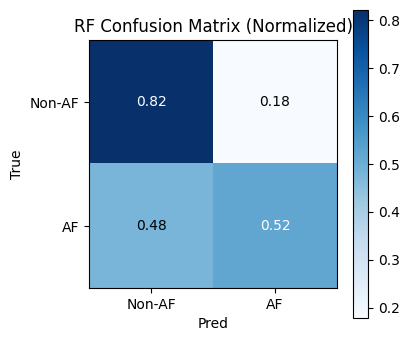

In [21]:
# --- Train/test split (This is ALREADY DONE at patient level for features) ---
# We now use the pre-split feature DataFrames
# X_train, X_test, y_train, y_test = train_test_split(...) # This line is removed/commented

# Pipeline & model (Your existing pipeline is fine)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Ensure there's data left after NaN drop
if X_train_feat_df.empty or X_test_feat_df.empty:
    print("Training or testing feature DataFrame is empty after NaN drop. Cannot proceed.")
else:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')) # Added class_weight
    ])

    pipe.fit(X_train_feat_df, y_train_rf)
    print("Random Forest training complete.")

    # Model Evaluation for Random Forest
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
    import matplotlib.pyplot as plt  # Import matplotlib

    y_pred_rf = pipe.predict(X_test_feat_df)

    # Debugging: Print shapes
    print("Shape of y_test_rf:", y_test_rf.shape)
    print("Shape of X_test_feat_df:", X_test_feat_df.shape)

    try:
        y_pred_proba_rf = pipe.predict_proba(X_test_feat_df)[:, 1] # For AUC

        print("\nRandom Forest Classification Report:")
        print(classification_report(y_test_rf, y_pred_rf))
        print("Random Forest AUC:", roc_auc_score(y_test_rf, y_pred_proba_rf))

        cm_rf = confusion_matrix(y_test_rf, y_pred_rf, normalize='true')
        plt.figure(figsize=(4,4))
        plt.imshow(cm_rf, cmap='Blues', interpolation='nearest')
        plt.title("RF Confusion Matrix (Normalized)")
        plt.colorbar()
        plt.xticks([0,1], ['Non-AF','AF'])
        plt.yticks([0,1], ['Non-AF','AF'])
        for i in range(cm_rf.shape[0]):
            for j in range(cm_rf.shape[1]):
                plt.text(j, i, format(cm_rf[i, j], '.2f'),
                         ha="center", va="center",
                         color="white" if cm_rf[i, j] > 0.5 else "black")
        plt.ylabel('True')
        plt.xlabel('Pred')
        plt.show()

    except IndexError as e:
        print(f"IndexError during predict_proba: {e}")
        print("Shape of predict_proba output:", pipe.predict_proba(X_test_feat_df).shape) # Print the shape to debug
        # Optionally, print the first few rows of the output to inspect its structure
        print("First few rows of predict_proba output:", pipe.predict_proba(X_test_feat_df)[:5])

**1D CNN (Keras)**

In [22]:
# # Prepare raw segments for CNN
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # One-hot labels
# y = tf.keras.utils.to_categorical(is_af.astype(int), num_classes=2)

# # Shuffle & split
# idx = np.random.permutation(len(segments))
# split = int(0.8 * len(idx))
# train_idx, test_idx = idx[:split], idx[split:]

# X_train, X_test = segments[train_idx][..., np.newaxis], segments[test_idx][..., np.newaxis]
# y_train, y_test = y[train_idx], y[test_idx]

# # Build CNN
# model = models.Sequential([
#     layers.Conv1D(32, 5, activation='relu', input_shape=(1250,1)),
#     layers.MaxPool1D(2),
#     layers.Conv1D(64, 5, activation='relu'),
#     layers.MaxPool1D(2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(2, activation='softmax'),
# ])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()
# history = model.fit(X_train, y_train, epochs=5, batch_size=32,
#           validation_data=(X_test, y_test))



X_train_cnn shape: (131848, 1250, 1), y_train_cnn shape: (131848, 2)
X_test_cnn shape: (36820, 1250, 1), y_test_cnn shape: (36820, 2)


/Users/animesh/miniforge3/envs/tfmac/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-11 16:52:31.073617: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-11 16:52:31.074003: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-11 16:52:31.074302: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-11 16:52:31.074498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-11 16:52:31.074961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1246, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 623, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 619, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 309, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,265,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,354 (4.87 MB)

 Trainable params: 1,276,354 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-05-11 16:52:41.968357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4121/4121 ━━━━━━━━━━━━━━━━━━━━ 122s 28ms/step - accuracy: 0.7464 - loss: 0.5620 - val_accuracy: 0.7279 - val_loss: 0.6451
Epoch 2/50
4121/4121 ━━━━━━━━━━━━━━━━━━━━ 103s 25ms/step - accuracy: 0.8853 - loss: 0.3282 - val_accuracy: 0.5805 - val_loss: 2.2517
Epoch 3/50
4121/4121 ━━━━━━━━━━━━━━━━━━━━ 98s 24ms/step - accuracy: 0.7455 - loss: 2.4252 - val_accuracy: 0.6584 - val_loss: 5.4405
Epoch 4/50
4121/4121 ━━━━━━━━━━━━━━━━━━━━ 107s 26ms/step - accuracy: 0.6864 - loss: 4.9974 - val_accuracy: 0.5977 - val_loss: 6.4303
Epoch 5/50
4121/4121 ━━━━━━━━━━━━━━━━━━━━ 125s 30ms/step - accuracy: 0.6711 - loss: 5.2782 - val_accuracy: 0.5970 - val_loss: 6.4659
Epoch 6/50
4121/4121 ━━━━━━━━━━━━━━━━━━━━ 98s 24ms/step - accuracy: 0.6500 - loss: 5.6279 - val_accuracy: 0.5067 - val_loss: 7.9362
CNN training complete.
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     22917
           1

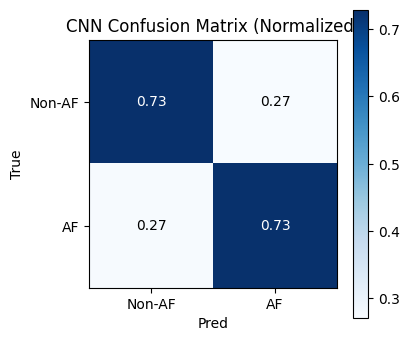

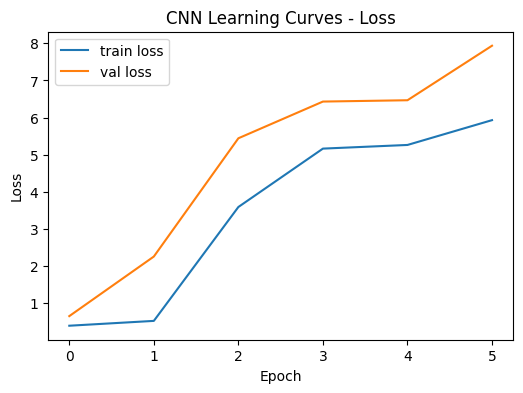

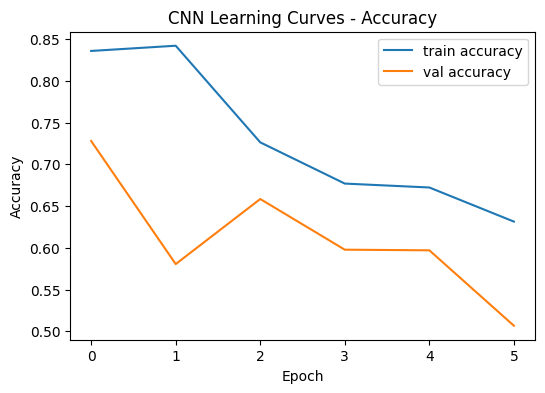

In [23]:
# --- Prepare raw segments for CNN (Modified) ---
# We use the patient-aware splits: train_segments and test_segments
# And the corresponding binary labels: train_is_af and test_is_af

# Ensure segments are not empty
if train_segments.size == 0 or test_segments.size == 0:
    print("Training or testing segments array is empty. Cannot proceed with CNN.")
else:
    X_train_cnn = train_segments[..., np.newaxis] # Add channel dimension
    X_test_cnn = test_segments[..., np.newaxis]   # Add channel dimension

    # One-hot labels
    y_train_cnn = tf.keras.utils.to_categorical(train_is_af.astype(int), num_classes=2)
    y_test_cnn = tf.keras.utils.to_categorical(test_is_af.astype(int), num_classes=2)

    print(f"X_train_cnn shape: {X_train_cnn.shape}, y_train_cnn shape: {y_train_cnn.shape}")
    print(f"X_test_cnn shape: {X_test_cnn.shape}, y_test_cnn shape: {y_test_cnn.shape}")


    # Build CNN (Your existing model architecture is fine)
    model_cnn = models.Sequential([
        layers.Conv1D(32, 5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)), # (1250,1)
        layers.MaxPool1D(2),
        layers.Conv1D(64, 5, activation='relu'),
        layers.MaxPool1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax'),
    ])

    model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model_cnn.summary()

    # Consider class weights for imbalanced data for the CNN as well
    # from sklearn.utils import class_weight
    # class_weights_cnn = class_weight.compute_class_weight('balanced',
    #                                                     classes=np.unique(train_is_af.astype(int)),
    #                                                     y=train_is_af.astype(int))
    # class_weights_cnn_dict = dict(enumerate(class_weights_cnn))
    # print(f"CNN Class Weights: {class_weights_cnn_dict}")

    history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=32,
                                validation_data=(X_test_cnn, y_test_cnn),
                                # class_weight=class_weights_cnn_dict # Optional: add class weights
                                callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)] # Early stopping
                               )
    print("CNN training complete.")

    # CNN evaluation
    cnn_preds_proba = model_cnn.predict(X_test_cnn)
    cnn_preds = cnn_preds_proba.argmax(axis=1)
    y_test_cnn_labels = y_test_cnn.argmax(axis=1) # Convert one-hot back to labels for classification_report

    print("\nCNN Classification Report:")
    print(classification_report(y_test_cnn_labels, cnn_preds))
    print("CNN AUC:", roc_auc_score(y_test_cnn, cnn_preds_proba))


    cm_cnn = confusion_matrix(y_test_cnn_labels, cnn_preds, normalize='true')
    plt.figure(figsize=(4,4))
    plt.imshow(cm_cnn, cmap='Blues', interpolation='nearest')
    plt.title("CNN Confusion Matrix (Normalized)")
    plt.colorbar()
    plt.xticks([0,1], ['Non-AF','AF'])
    plt.yticks([0,1], ['Non-AF','AF'])
    for i in range(cm_cnn.shape[0]):
        for j in range(cm_cnn.shape[1]):
            plt.text(j, i, format(cm_cnn[i, j], '.2f'),
                     ha="center", va="center",
                     color="white" if cm_cnn[i, j] > 0.5 else "black")
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.show()

    # Learning curves (CNN)
    hist_cnn_dict = history_cnn.history
    plt.figure(figsize=(6,4))
    plt.plot(hist_cnn_dict['loss'], label='train loss')
    plt.plot(hist_cnn_dict['val_loss'], label='val loss')
    plt.title("CNN Learning Curves - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist_cnn_dict['accuracy'], label='train accuracy')
    plt.plot(hist_cnn_dict['val_accuracy'], label='val accuracy')
    plt.title("CNN Learning Curves - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Model Evaluation & Validation

**Classical ML evaluation**

In [24]:
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# import matplotlib.pyplot as plt

# # Assuming 'df_feat' contains the features used for training the Random Forest
# # Select the same test indices used for CNN to create a new X_test for the Random Forest
# X_test_rf = df_feat.drop(columns='AF').iloc[test_idx]

# # Now predict using the feature dataframe
# y_pred = pipe.predict(X_test_rf)

# print(classification_report(y_test.argmax(axis=1), y_pred))

# cm = confusion_matrix(y_test.argmax(axis=1), y_pred, normalize='true')  # Use argmax here
# plt.figure(figsize=(4,4))
# plt.imshow(cm, cmap='Blues')
# plt.title("RF Confusion Matrix")
# plt.colorbar()
# plt.xticks([0,1], ['Non-AF','AF'])
# plt.yticks([0,1], ['Non-AF','AF'])
# plt.ylabel('True')
# plt.xlabel('Pred')
# plt.show()

**CNN evaluation**

In [25]:
# # Assuming 'history' is the variable holding the training history from model.fit()

# # CNN evaluation
# cnn_preds = model.predict(X_test).argmax(axis=1)
# print(classification_report(y_test.argmax(axis=1), cnn_preds))
# print("CNN AUC:", roc_auc_score(y_test, model.predict(X_test)))

# # 4.3 Learning curves (CNN)
# hist = history.history  # Access history from the 'history' object
# plt.figure(figsize=(6,4))
# plt.plot(hist['loss'], label='train loss')
# plt.plot(hist['val_loss'], label='val loss')
# plt.title("CNN Learning Curves")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()